In [4]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

dataset = pd.read_csv('dataset.csv', sep=';', parse_dates=True, index_col=0)
model = tf.keras.models.load_model('LATEST_best_model_single.keras')

def smape(A, F):
    from keras import ops
    return 1/len(A) * ops.sum(2 * ops.abs(F - A) / (ops.abs(A) + ops.abs(F)))

learning_rate = model.optimizer.get_config()['learning_rate']
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.MeanAbsoluteError()

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()],
              run_eagerly = True)



c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [5]:
def create_dataset(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size):
    # Feel free to play with shuffle buffer size
    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df)
    
    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data
    data = data.shuffle(shuffle_buffer_size, seed=42)

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'

train_df = dataset.loc[:train_split]
val_df = dataset.loc[train_split:val_split]
test_df = dataset.loc[val_split:]

x_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]

x_val = val_df.iloc[:, 1:]
y_val = val_df.iloc[:, 0]

x_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

scaler = MinMaxScaler()
scaler_target = MinMaxScaler()

scaler.fit(x_train)
scaler_target.fit(y_train.values.reshape(-1, 1))

x_train = scaler.transform(x_train)
y_train = scaler_target.transform(y_train.values.reshape(-1, 1))

x_val = scaler.transform(x_val)
y_val = scaler_target.transform(y_val.values.reshape(-1, 1))

x_test = scaler.transform(x_test)
y_test = scaler_target.transform(y_test.values.reshape(-1, 1))

In [3]:
def create_sample(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size ):
    # Feel free to play with shuffle buffer size
    # shuffle_buffer_size = len(df)
    
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df)
    
    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    
    #tf.data.experimental.AUTOTUNE
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

start = "2023-01-05 23:00:00"
end = str((pd.Timestamp(start) + pd.Timedelta("599 hours")))

futr_exog_list = len(dataset.iloc[:, 40:].columns.to_list())
window_len = 24 * 5 * 4
forecast_len = 24 * 5

y_sample_real = test_df[start:end].spotPrice.values
x_sample_real = test_df[start:end].drop("spotPrice", axis=1)

y_sample_real = scaler_target.transform(y_sample_real.reshape(-1,1))
x_sample_real = scaler.transform(x_sample_real)

sample_real = np.concatenate([y_sample_real, x_sample_real], axis = 1)



sample_windowed = create_sample(sample_real,
                               futr_exog_list,
                               window_len,
                               forecast_len,
                               batch_size=1)

In [ ]:
def create_sample(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size ):
    # Feel free to play with shuffle buffer size
    # shuffle_buffer_size = len(df)
    
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df)
    
    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    
    #tf.data.experimental.AUTOTUNE
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Parameters
start = "2023-01-05 23:00:00"
time_stride = pd.Timedelta("120 hours")
window_len = 24 * 5 * 4
forecast_len = 24 * 5
futr_exog_list = len(dataset.iloc[:, 40:].columns.to_list())
batch_size = 1

# Loop through the test_df in 120-hour increments
current_start = pd.Timestamp(start)
samples = []

while current_start + pd.Timedelta(hours=window_len + forecast_len) <= test_df.index[-1]:
    # Define the current end time for the window
    current_end = current_start + pd.Timedelta(hours=window_len + forecast_len)
    
    # Select the data for the current window
    y_sample_real = test_df.loc[current_start:current_end, 'spotPrice'].values
    x_sample_real = test_df.loc[current_start:current_end].drop("spotPrice", axis=1).values

    # Scale the data
    y_sample_real = scaler_target.transform(y_sample_real.reshape(-1,1))
    x_sample_real = scaler.transform(x_sample_real)

    # Concatenate target and features for sample creation
    sample_real = np.concatenate([y_sample_real, x_sample_real], axis=1)

    # Create windowed sample and append to list
    sample_windowed = create_sample(sample_real,
                                    futr_exog_list,
                                    window_len,
                                    forecast_len,
                                    batch_size)
    samples.append(sample_windowed)
    
    # Increment the start time by the defined stride
    current_start += time_stride

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

N_SAMPLES = 100

z_lower_array = []
z_upper_array = []

predictions_means = []
reals_scaled = []

mae_array = []
mse_array = []
rmse_array = []
smape_array = []

for j in samples:
    unbatch = j.as_numpy_iterator().next()
    x, real = unbatch
    preds = np.stack([model(x, training = True) for i in range(N_SAMPLES)]) 
    preds = preds.squeeze()
    
    Y_hat = scaler_target.inverse_transform(preds)
    preds_quantiles = np.percentile(Y_hat, q=[2.5, 97.5], axis=0)
    mean_pred = np.mean(Y_hat, axis=0)
    real_scaled = scaler_target.inverse_transform(real).squeeze()
    
    z_lower_array.append(preds_quantiles[0])
    z_upper_array.append(preds_quantiles[1])
    
    
    predictions_means.append(mean_pred)
    reals_scaled.append(scaler_target.inverse_transform(real).squeeze())
    
    mae_array.append(mean_absolute_error(real_scaled, mean_pred))
    mse_array.append(mean_squared_error(real_scaled, mean_pred))
    rmse_array.append(root_mean_squared_error(real_scaled, mean_pred))
    smape_array.append(smape(real_scaled, mean_pred))
    
metrics = pd.DataFrame({
    'MAE' : mae_array,
    'MSE' : mse_array,
    'RMSE' : rmse_array,
    'SMAPE' : smape_array
})

C:\Users\drami\AppData\Local\Temp\ipykernel_37660\2761211463.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


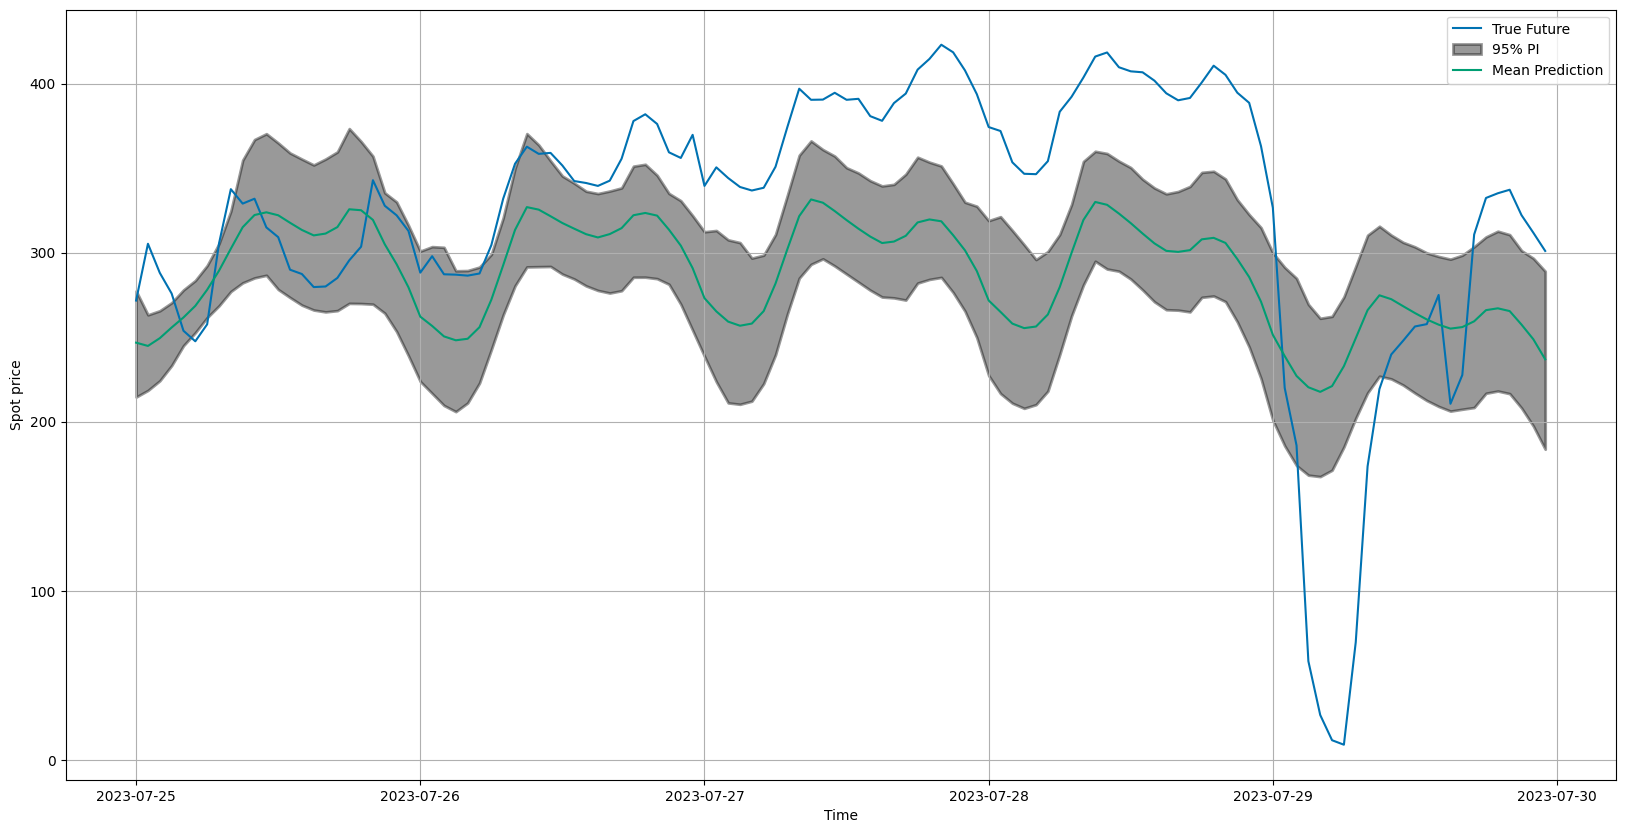

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.style.use('seaborn-colorblind')

INDEX = 36

predictions_means_ = predictions_means[INDEX]
z_lower_array_ = z_lower_array[INDEX]
z_upper_array_ = z_upper_array[INDEX]
reals_scaled_ = reals_scaled[INDEX]
time_index = test_df[(601 + (INDEX * 120)):(601 + (INDEX * 120)) + 120].index

plt.plot(time_index, reals_scaled_, label="True Future")
plt.fill_between(time_index, z_lower_array_, z_upper_array_, color='black', alpha= .4, lw = 2, label="95% PI")
plt.plot(time_index, predictions_means_, label="Mean Prediction")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Spot price")
plt.grid(axis= 'x')
plt.grid(axis= 'y')
plt.show()


In [78]:
mean_absolute_error(reals_scaled_, predictions_means_)

116.61136

In [74]:
predictions_means[INDEX]

array([473.5268 , 475.5866 , 497.06235, 503.64453, 495.5974 , 480.8969 ,
       475.57977, 483.76065, 522.82654, 554.41095, 558.37946, 553.3995 ,
       547.6514 , 542.0819 , 537.2824 , 536.21954, 541.5491 , 549.865  ,
       563.94806, 566.34467, 561.7319 , 544.7615 , 523.5514 , 503.31448,
       480.64578, 473.31808, 470.20117, 467.7475 , 471.14352, 481.78317,
       502.13672, 536.7468 , 576.0374 , 598.17   , 596.9187 , 588.94385,
       579.1433 , 570.8894 , 562.64703, 557.47797, 559.43317, 565.25867,
       575.9051 , 576.20276, 568.6908 , 549.5953 , 529.4818 , 512.23474,
       490.3013 , 481.0356 , 475.90747, 470.86533, 471.3023 , 478.31534,
       493.80548, 516.76245, 547.73975, 569.8357 , 570.2931 , 563.98584,
       556.78564, 551.7085 , 545.865  , 541.942  , 544.8015 , 551.0758 ,
       560.9197 , 561.8332 , 557.3467 , 543.63654, 529.2979 , 515.524  ,
       495.5857 , 487.30835, 483.89667, 480.1073 , 482.48285, 490.73364,
       506.99176, 530.2993 , 558.2218 , 576.973  , 

C:\Users\drami\AppData\Local\Temp\ipykernel_37660\4079141696.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


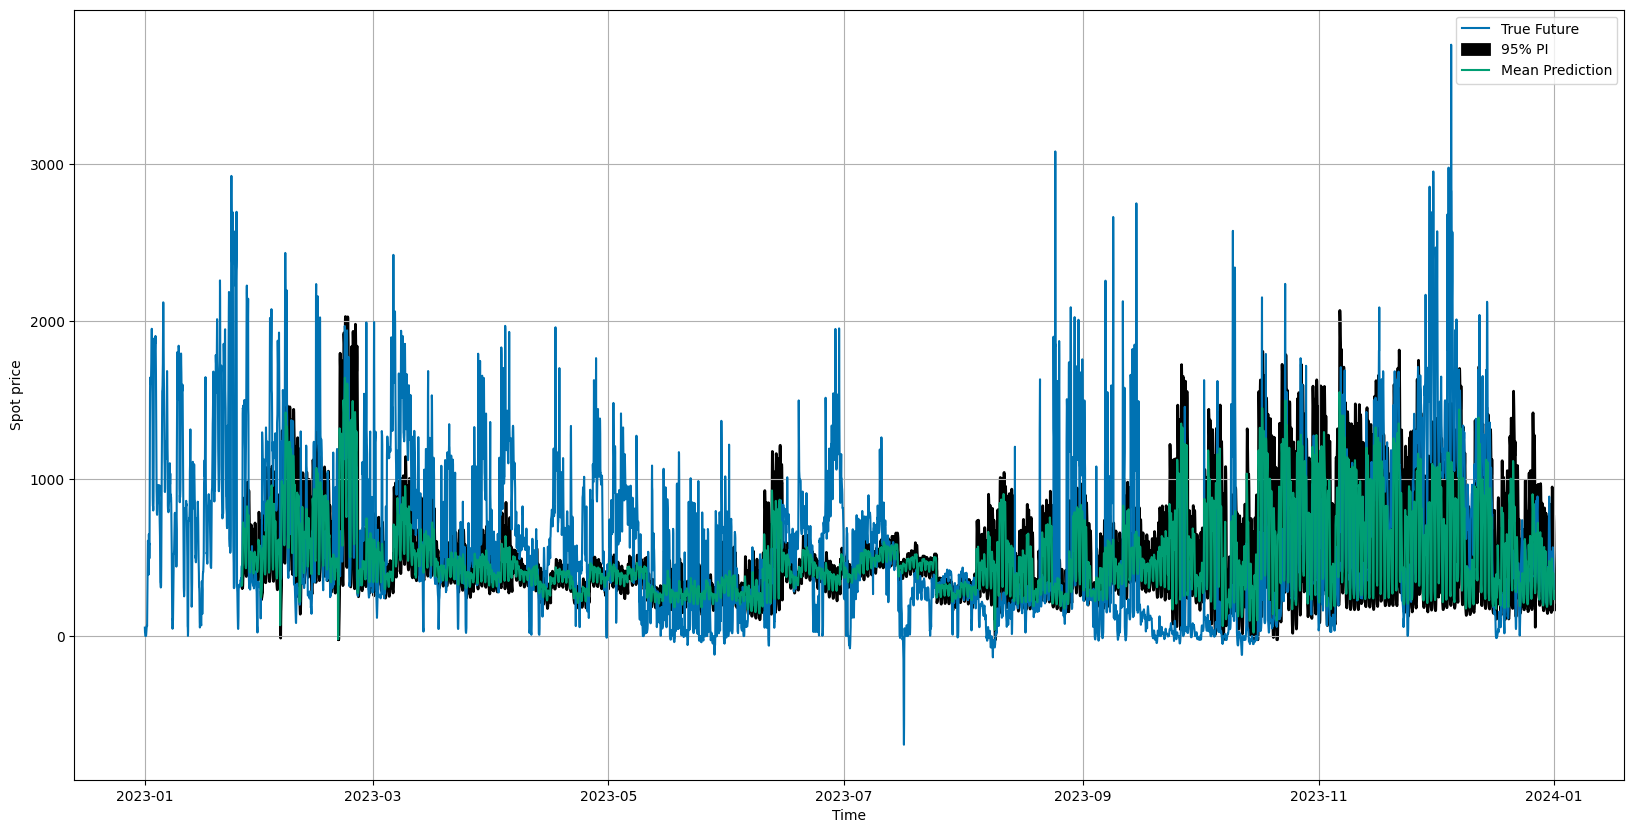

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.style.use('seaborn-colorblind')
predictions_means_ = np.concatenate(predictions_means, axis = 0)
z_lower_array_ = np.concatenate(z_lower_array, axis = 0)
z_upper_array_ = np.concatenate(z_upper_array, axis = 0)
reals_scaled_ = np.concatenate(reals_scaled, axis = 0)
time_index = test_df[601:].index

# plt.plot(time_index, reals_scaled_, label="True Future")
plt.plot(test_df.spotPrice, label="True Future")
plt.fill_between(time_index, z_lower_array_, z_upper_array_, color='black', alpha= 1, lw = 2, label="95% PI")
plt.plot(time_index, predictions_means_, label="Mean Prediction")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Spot price")
plt.grid(axis= 'x')
plt.grid(axis= 'y')
plt.show()


In [42]:
scaler_target.inverse_transform(reals_scaled_.reshape(1, -1)).flatten()

(8160,)

In [6]:
unbatch = sample_windowed.as_numpy_iterator().next()
x, real = unbatch

SAMPLES = 100
preds = np.stack([model(x, training = True) for i in range(SAMPLES)])
preds = preds.squeeze()


Y_hat = scaler_target.inverse_transform(preds)
preds_quantiles = np.percentile(Y_hat, q=[2.5, 97.5], axis=0)
z_lower = preds_quantiles[0]
z_upper = preds_quantiles[1]

C:\Users\drami\AppData\Local\Temp\ipykernel_37660\286274920.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


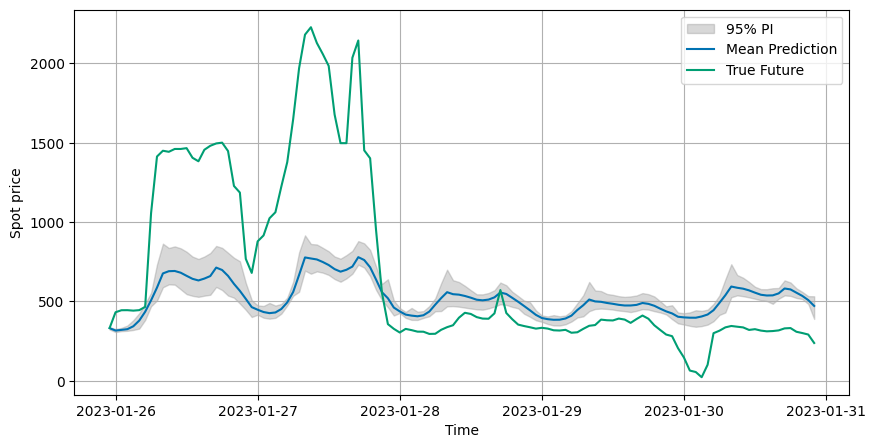

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.style.use('seaborn-colorblind')


time_index = dataset[start:end].spotPrice.tail(120).index
mean_prediction = np.mean(Y_hat, axis=0)
real_scaled = scaler_target.inverse_transform(real).squeeze()

plt.fill_between(time_index, z_lower, z_upper, color='gray', alpha= .3, lw = 1, label="95% PI")
plt.plot(time_index, mean_prediction, label="Mean Prediction")
plt.plot(time_index, scaler_target.inverse_transform(real).squeeze(), label="True Future")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Spot price")
plt.grid(axis= 'x')
plt.grid(axis= 'y')
plt.show()